# Seismic Signal Processing with ObsPy

## Fourier Transform and Power Spectral Densities

[Probabilistic Power Spectral Densities](https://docs.obspy.org/tutorial/code_snippets/probabilistic_power_spectral_density.html)

In [1]:
import obspy
from obspy import read
from obspy.io.xseed import Parser
from obspy.signal import PPSD
from obspy import read_inventory
from obspy.imaging.cm import pqlx
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cwt, morlet, hilbert, stft


### Frequency of earthquakes

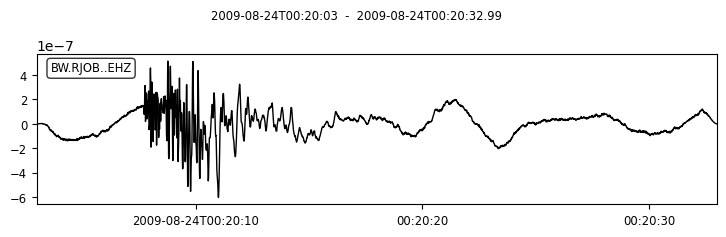

In [2]:
st = obspy.read()
st.remove_sensitivity()
tr = st[0]
tr.plot();

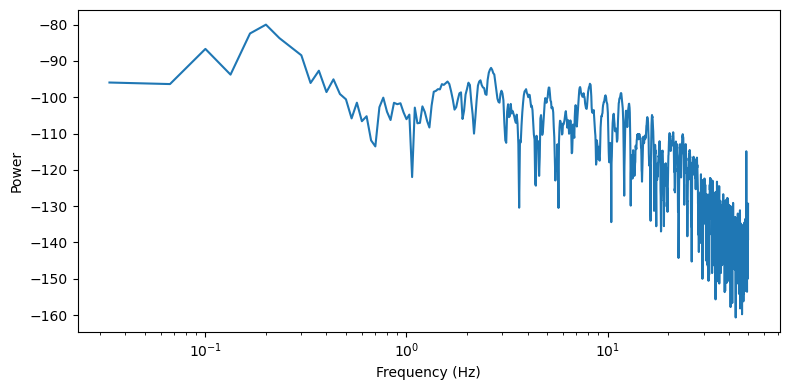

In [3]:
p, f = tr.data, tr.stats.sampling_rate
psd = np.abs(np.fft.fft(p))**2
freq = np.fft.fftfreq(p.size, d=1./f)

# Only consider positive frequencies for plotting
mask = freq > 0
psd, freq = psd[mask], freq[mask]
psd = 10. * np.log10(psd) # Convert to dB

plt.figure(figsize=(8, 4))
plt.semilogx(freq, psd)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.tight_layout()
plt.show()

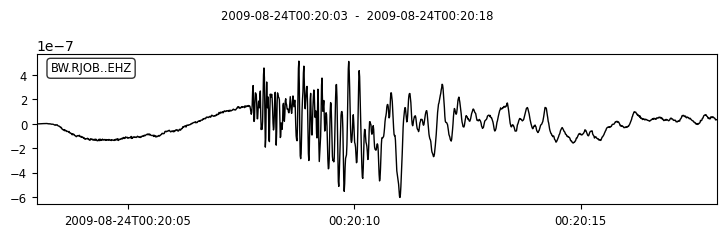

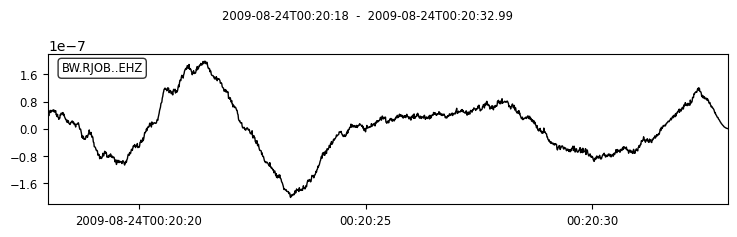

In [4]:
starttime = tr.stats.starttime
end_time = tr.stats.endtime
mid_time = starttime + (end_time - starttime)/2
tr_eq = tr.slice(starttime=starttime, endtime=mid_time)
tr_ns = tr.slice(starttime=mid_time, endtime=end_time)
tr_eq.plot();
tr_ns.plot();

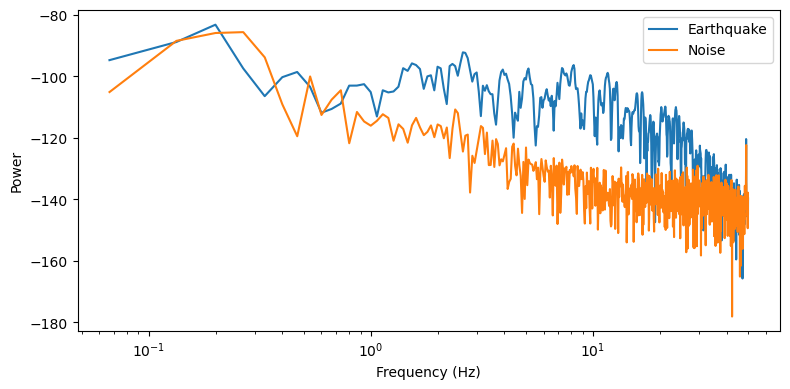

In [5]:
p_eq, f_eq = tr_eq.data, tr_eq.stats.sampling_rate
psd_eq = np.abs(np.fft.fft(p_eq))**2
freq_eq = np.fft.fftfreq(p_eq.size, d=1./f_eq)

p_ns, f_ns = tr_ns.data, tr_ns.stats.sampling_rate
psd_ns = np.abs(np.fft.fft(p_ns))**2
freq_ns = np.fft.fftfreq(p_ns.size, d=1./f_ns)

mask_eq = freq_eq > 0
psd_eq, freq_eq = psd_eq[mask_eq], freq_eq[mask_eq]
mask_ns = freq_ns > 0
psd_ns, freq_ns = psd_ns[mask_ns], freq_ns[mask_ns]

psd_eq = 10. * np.log10(psd_eq) 
psd_ns = 10. * np.log10(psd_ns)

plt.figure(figsize=(8, 4))
plt.semilogx(freq_eq, psd_eq, label='Earthquake')
plt.semilogx(freq_ns, psd_ns, label='Noise')
plt.xlabel("Frequency (Hz)")
# plt.xlabel("Period (s)")
plt.ylabel("Power")
plt.legend()
plt.tight_layout()
plt.show()


### PSD of ambient noise

In [6]:
st = read("https://examples.obspy.org/BW.KW1..EHZ.D.2011.037")
tr = st.select(id="BW.KW1..EHZ")[0]
inv = read_inventory("https://examples.obspy.org/BW_KW1.xml")

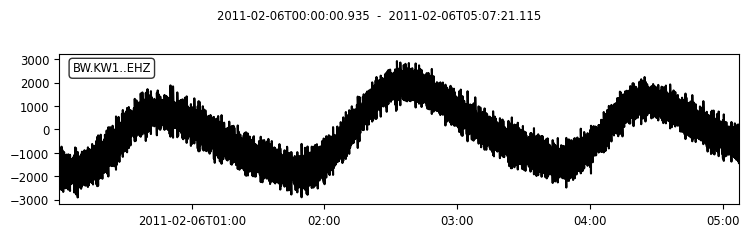

In [7]:
tr.plot();

In [8]:
ppsd = PPSD(tr.stats, metadata=inv)
ppsd.add(st)

True

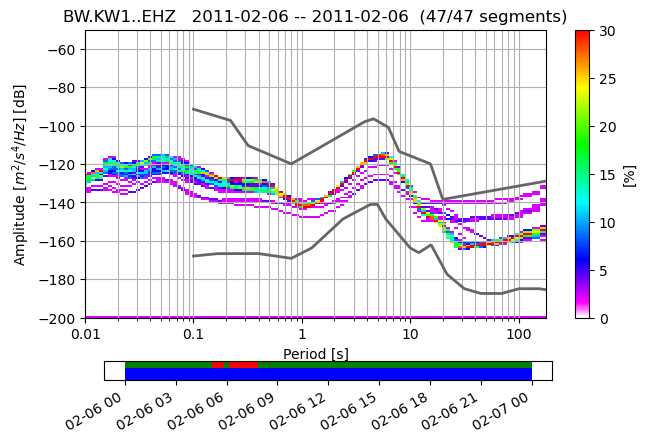

In [9]:
ppsd.plot(cmap=pqlx);

### [Reading: Microseism](https://en.wikipedia.org/wiki/Microseism)
![](https://upload.wikimedia.org/wikipedia/commons/5/5c/ANMO_20_years.jpg)

## Filtering

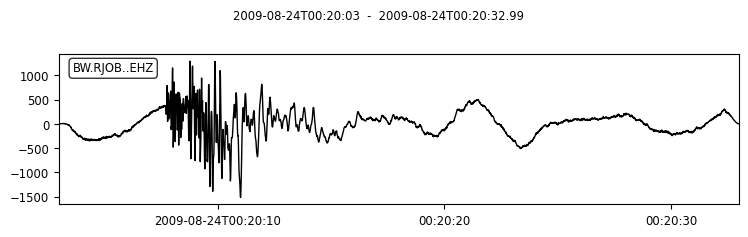

In [10]:
st = obspy.read()
tr = st[0]
tr.plot(title="Original Data");

- High pass filter

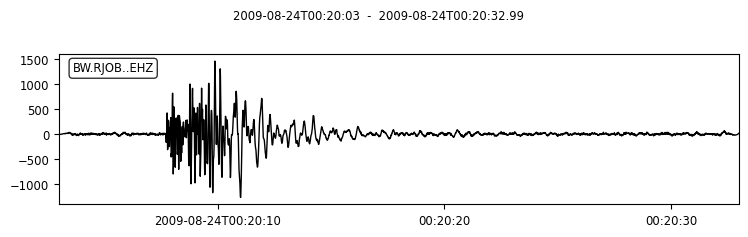

In [11]:
tr_highpass = tr.copy()
tr_highpass.filter('highpass', freq=1.0, corners=2, zerophase=True)
tr_highpass.plot(title="Highpass Filtered Data");

- TODO: Low pass filter

In [12]:
tr_lowpass = tr.copy()

- TODO: Band pass filter

In [13]:
tr_bandpass = tr.copy()

## Spectrogram

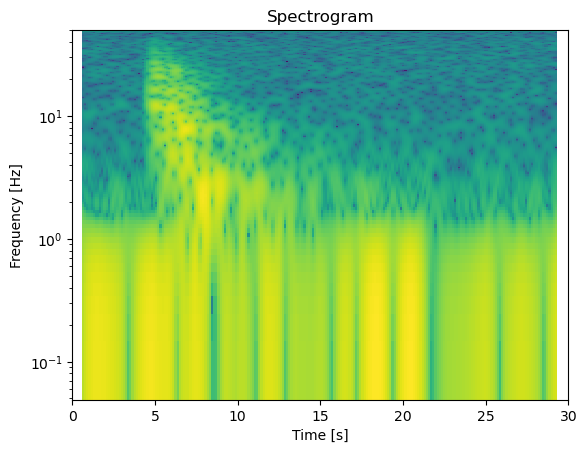

In [14]:
st = obspy.read()
tr = st[0]
tr.spectrogram(log=True, title="Spectrogram", dbscale=True, show=True, cmap='viridis');

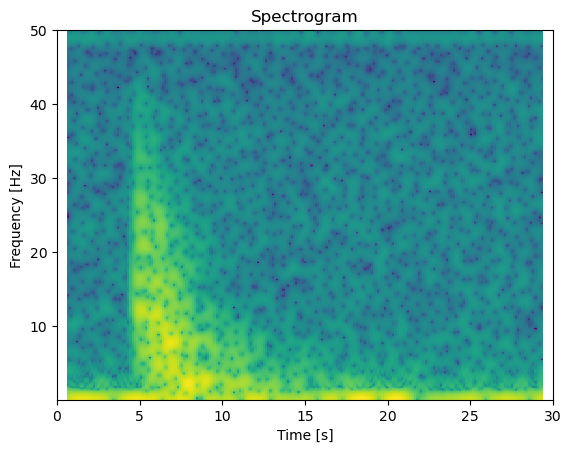

In [15]:
tr.spectrogram(log=False, title="Spectrogram", dbscale=True, show=True, cmap='viridis');

### Using STFT (Short Time Fourier Transform)

Note:

**nperseg** is the length of each segment.

**noverlap** is the number of points to overlap between segments.

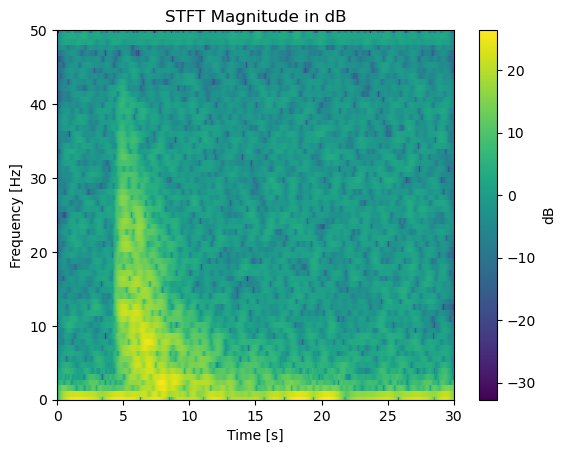

In [16]:
st = obspy.read()
tr = st[0]

# Compute the STFT
frequencies, times, Zxx = stft(tr.data, fs=tr.stats.sampling_rate, nperseg=128, noverlap=127)

# Convert to dB
Zxx_dB = 10. * np.log10(np.abs(Zxx))

plt.figure()
plt.pcolormesh(times, frequencies, Zxx_dB, shading='auto', cmap='viridis')
plt.title('STFT Magnitude in dB')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='dB')
plt.ylim([0, 50])  # Limit frequency range for display
plt.show()

- TODO: Change the values of nperseg and noverlap to see the effect.

- TODO: Visualize the spectrogram after filtering

### Extension Reading: Using Wavelet Transform for time-frequency analysis

[Wavelet Transform](https://en.wikipedia.org/wiki/Wavelet_transform)

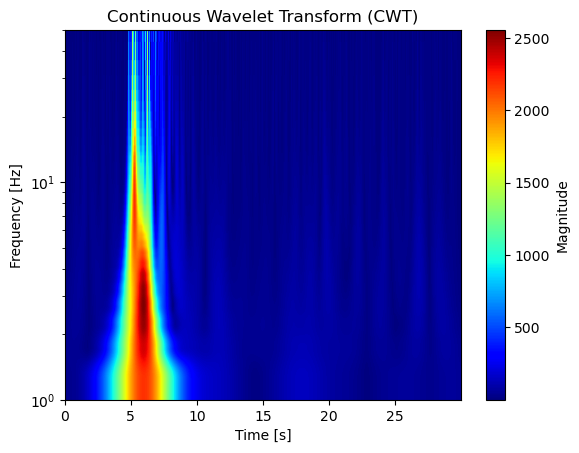

In [17]:
# Define a range of desired center frequencies (in Hz)
desired_frequencies = np.linspace(1, 50, 100)  # Example: 100 frequencies between 1 Hz and 50 Hz

# Compute the associated wavelet widths for these frequencies
dt = tr.stats.delta
widths = np.round(2 / (desired_frequencies * dt)).astype(int)

# Compute the CWT using the Morlet wavelet
cwt_matrix = cwt(tr.data, morlet, widths)

# Convert to magnitude for visualization
cwt_magnitude = np.abs(cwt_matrix)

plt.imshow(cwt_magnitude, extent=[0, tr.stats.endtime - tr.stats.starttime, desired_frequencies[0], desired_frequencies[-1]], aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform (CWT)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.yscale('log')  # Logarithmic frequency scale can often be more informative
plt.show()

### Seismogram Envelopes

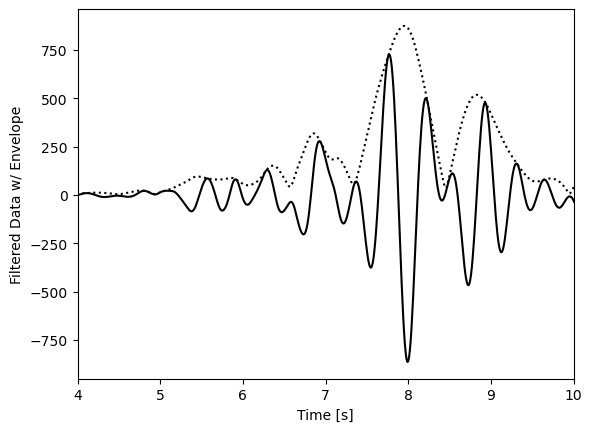

In [18]:
st = obspy.read()
tr = st[0]

tr_filt = tr.copy()
tr_filt.filter('bandpass', freqmin=1, freqmax=3, corners=2, zerophase=True)

data_envelope = obspy.signal.filter.envelope(tr_filt.data)

t = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, 1 / tr.stats.sampling_rate)
plt.plot(t, tr_filt.data, 'k')
plt.plot(t, data_envelope, 'k:')
plt.ylabel('Filtered Data w/ Envelope')
plt.xlabel('Time [s]')
plt.xlim(4, 10)
plt.show()

### Using Hilbert Transform

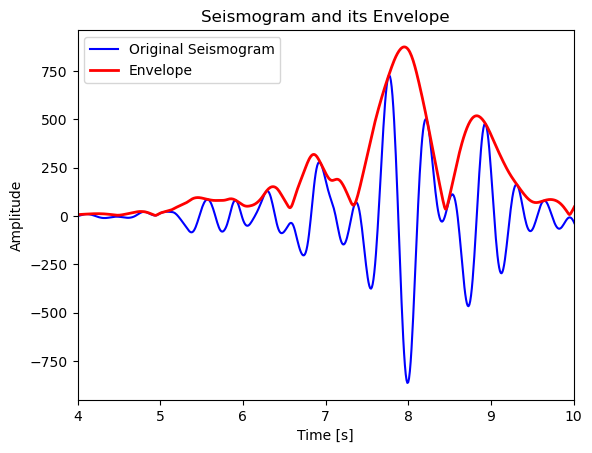

In [23]:
analytic_signal = hilbert(tr_filt.data)
envelope = np.abs(analytic_signal)

plt.figure()
plt.plot(t, tr_filt.data, label="Original Seismogram", color='blue')
plt.plot(t, envelope, label="Envelope", color='red', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Seismogram and its Envelope")
plt.legend()
plt.xlim(4, 10)
plt.show()